# Classification  With Decision Trees



In [1]:

import pandas as pd

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.datasets import make_moons, load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix
from typing import Optional
from pydantic import BaseModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from fastapi.encoders import jsonable_encoder
from fastapi import FastAPI
from enum import Enum
import os
import io
import pickle
import uvicorn
import nest_asyncio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
moons_data = make_moons(n_samples=10000, noise=.4)

In [3]:
X, y = moons_data
print(X.shape)
y = y.reshape(-1,1)
print(y.shape)

(10000, 2)
(10000, 1)


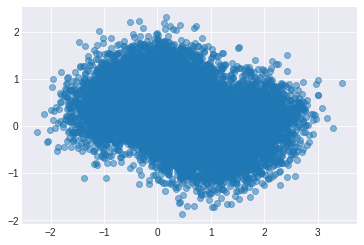

In [4]:
plt.style.use(['seaborn-darkgrid'])
plt.scatter(x=X[:, 0], y=X[:, 1], alpha=.5)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 2)
(2000, 2)
(8000, 1)
(2000, 1)


In [6]:
# We have good ratio for each class
print(np.sum(y_test==0))
print(np.sum(y_test==1))

1011
989


In [7]:
parameters = {'max_depth': list(np.linspace(5, 50, 10).astype(int)),
             'min_samples_split': list(np.linspace(5, 30, 5).astype(int)), 
             'max_leaf_nodes': [int(np.log2(X_train.shape[0])), 5, 100, 200]}

In [8]:
tree_1 = DecisionTreeClassifier()
grd_serch = GridSearchCV(tree_1, parameters, cv=3)
grd_serch.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                         'max_leaf_nodes': [12, 5, 100, 200],
                         'min_samples_split': [5, 11, 17, 23, 30]})

In [9]:
cv_grd_search = grd_serch.cv_results_
for mean_score, params in zip(cv_grd_search['mean_test_score'], cv_grd_search['params']):
    print(mean_score, params)

0.8506256204096019 {'max_depth': 5, 'max_leaf_nodes': 12, 'min_samples_split': 5}
0.8506256204096019 {'max_depth': 5, 'max_leaf_nodes': 12, 'min_samples_split': 11}
0.8506256204096019 {'max_depth': 5, 'max_leaf_nodes': 12, 'min_samples_split': 17}
0.8506256204096019 {'max_depth': 5, 'max_leaf_nodes': 12, 'min_samples_split': 23}
0.8506256204096019 {'max_depth': 5, 'max_leaf_nodes': 12, 'min_samples_split': 30}
0.8506256204096019 {'max_depth': 5, 'max_leaf_nodes': 5, 'min_samples_split': 5}
0.8506256204096019 {'max_depth': 5, 'max_leaf_nodes': 5, 'min_samples_split': 11}
0.8506256204096019 {'max_depth': 5, 'max_leaf_nodes': 5, 'min_samples_split': 17}
0.8506256204096019 {'max_depth': 5, 'max_leaf_nodes': 5, 'min_samples_split': 23}
0.8506256204096019 {'max_depth': 5, 'max_leaf_nodes': 5, 'min_samples_split': 30}
0.8478753546654381 {'max_depth': 5, 'max_leaf_nodes': 100, 'min_samples_split': 5}
0.8477503234076237 {'max_depth': 5, 'max_leaf_nodes': 100, 'min_samples_split': 11}
0.84775032

In [10]:
grd_serch.best_score_

0.8521254329330364

In [11]:
grd_serch.best_params_

{'max_depth': 10, 'max_leaf_nodes': 12, 'min_samples_split': 5}

# Tree 1

In [12]:
tree_model_1 = DecisionTreeClassifier(max_depth=10, min_samples_split=5, max_leaf_nodes=12)
tree_model_1.fit(X_train, y_train)

predict_train = tree_model_1.predict(X_train)
predict_test = tree_model_1.predict(X_test)

print(f1_score(y_train, predict_train))
print(confusion_matrix(y_train, predict_train))

print(f1_score(y_test, predict_test))
confusion_matrix(y_test, predict_test)

0.8570008696732514
[[3400  589]
 [ 562 3449]]
0.8681704260651629


array([[871, 140],
       [123, 866]])

# Tree 2

In [13]:
tree_model_2 = DecisionTreeClassifier(max_depth=9, min_samples_split=17, max_leaf_nodes=100)
tree_model_2.fit(X_train, y_train)

predict_train = tree_model_2.predict(X_train)
predict_test = tree_model_2.predict(X_test)

print(f1_score(y_train, predict_train))
print(confusion_matrix(y_train, predict_train))

print(f1_score(y_test, predict_test))
confusion_matrix(y_test, predict_test)

0.8758300964791379
[[3514  475]
 [ 516 3495]]
0.8558421851289832


array([[869, 142],
       [143, 846]])

# Note !

Seems good and no overfitting

In [14]:
# To know range of features
mins_feature1, maxs_feature1 = np.min(X_train[:, 0]), np.max(X_train[:, 0])
mins_feature2, maxs_feature2 = np.min(X_train[:, 1]), np.max(X_train[:, 0])
print(mins_feature1)
print("="*50)
print(maxs_feature1)
print("="*50)
print(mins_feature2)
print("="*50)
print(maxs_feature2)

-2.124341974055716
3.4494733225959138
-1.87761243452413
3.4494733225959138


In [15]:
def classification_model(features, accuracy_tr_ts):
    if accuracy_tr_ts == "tree_with_87%_train_and_85%_test":
        predict_class      = str(tree_model_2.predict(features)[0])
        predict_class_prob = str(tree_model_2.predict_proba(features))
    else:
        predict_class      = str(tree_model_1.predict(features)[0])
        predict_class_prob = str(tree_model_1.predict_proba(features))
    return predict_class, predict_class_prob

In [16]:
# Test the function
d = X_test[0]
d = d.reshape(1, -1)
print(tree_model_1.predict(d))
tree_model_1.predict_proba(d)
classification_model(d, 'tree_88_train_86_test')

[1]


('1', '[[0.25176471 0.74823529]]')

In [17]:

# Assign an instance of the FastAPI class to the variable "app".
# You will interact with your api using this instance.
app = FastAPI(title='Deploying a Decision Tree with FastAPI')

# List available models using Enum
class Tree_Type(str, Enum):
    Tree_with_85_on_test_set = "tree_with_87%_train_and_85%_test"
    Tree_with_86_on_test_set = "tree_with_85%_train_and_86%_test"


class Moon_Features(BaseModel):
    prom_user: str       = """Please use the two inputs below to insert value between -3 and 3
                                but include 0 before decimal point if you need to path decimal number"""
    feature_1: float     = 0.0 # client input
    feature_2: float     = 0.0 # client input
    predicted_class: str = "0" # returned based on our model
    predicted_class_prob: str = "[[0.0 0.0]]"  # returned based on our model
    
        

@app.get("/")
def home():
    # Once you go to this link you will see the get and post method below to trying out
    return "Head over to http://localhost:5001/docs."


# This endpoint handles all the logic necessary for the object detection to work.
# It requires the desired model and the dictionary of tweet and default class as we give default values to us
# In the api you can try other tweet from some_tweets below
@app.post("/classification") 
def classification_prediction(tree_type: Tree_Type, moon_features: Moon_Features):
    
    # Encode the retrived request data 
    moon_features = jsonable_encoder(moon_features)
    f1, f2 = moon_features['feature_1'], moon_features['feature_2']
    
    # Handle features for the model
    instance_to_predict = np.array([f1, f2]).reshape(1, -1) 

    
    predict_class, predict_class_prob = classification_model(instance_to_predict, Tree_Type)
    
    moon_features['predicted_class'], moon_features['predicted_class_prob'] = predict_class, predict_class_prob

    return moon_features

In [ ]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# Host depends on the setup you selected (docker or virtual env)
host = "0.0.0.0" if os.getenv("DOCKER-SETUP") else "127.0.0.1"

# uvicorn is fast Asynchronous Server Gateway Interface (ASGI) uvicorn handles the serving
# Spin up the server!    
uvicorn.run(app, host=host, port=5001)

INFO:     Started server process [19256]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:5001 (Press CTRL+C to quit)


INFO:     127.0.0.1:42360 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:42360 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:42364 - "POST /classification?tree_type=tree_with_87%25_train_and_85%25_test HTTP/1.1" 200 OK
INFO:     127.0.0.1:42370 - "POST /classification?tree_type=tree_with_85%25_train_and_86%25_test HTTP/1.1" 200 OK
INFO:     127.0.0.1:42374 - "POST /classification?tree_type=tree_with_85%25_train_and_86%25_test HTTP/1.1" 200 OK
INFO:     127.0.0.1:42378 - "POST /classification?tree_type=tree_with_87%25_train_and_85%25_test HTTP/1.1" 200 OK
INFO:     127.0.0.1:42382 - "POST /classification?tree_type=tree_with_87%25_train_and_85%25_test HTTP/1.1" 200 OK
INFO:     127.0.0.1:42386 - "POST /classification?tree_type=tree_with_85%25_train_and_86%25_test HTTP/1.1" 200 OK
INFO:     127.0.0.1:42392 - "POST /classification?tree_type=tree_with_85%25_train_and_86%25_test HTTP/1.1" 200 OK
INFO:     127.0.0.1:42396 - "POST /classification?tree_type=tree_with_85%25_train_